In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import ssl
import tensorflow as tf
os.environ['CURL_CA_BUNDLE'] = ''
ssl._create_default_https_context = ssl._create_unverified_context

In [18]:
def get_class_paths(path):
    classes = []
    class_paths = []
    # Iterate through directories in the training path
    for label in os.listdir(path):
        label_path = os.path.join(path, label)
        # Check if it's a directory
        if os.path.isdir(label_path):
            # Iterate through images in the label directory
            for image in os.listdir(label_path):
                image_path = os.path.join(label_path, image)
                # Add class and path to respective lists
                classes.append(label)
                class_paths.append(image_path)
    # Create a DataFrame with the collected data
    df = pd.DataFrame({
        'Class Path': class_paths,
        'Class': classes
    })
    return df

In [19]:
tr_df = get_class_paths("Training")

In [20]:
tr_df.head()

,Class Path,Class
0,Training/pituitary/Tr-pi_0505.jpg,pituitary
1,Training/pituitary/Tr-pi_0263.jpg,pituitary
2,Training/pituitary/Tr-pi_0277.jpg,pituitary
3,Training/pituitary/Tr-pi_1169.jpg,pituitary
4,Training/pituitary/Tr-pi_0511.jpg,pituitary


In [21]:
tr_df = get_class_paths("Training")

In [22]:
ts_df = get_class_paths("Testing")

In [23]:
ts_df

,Class Path,Class
0,Testing/pituitary/Te-pi_0233.jpg,pituitary
1,Testing/pituitary/Te-pi_0227.jpg,pituitary
2,Testing/pituitary/Te-pi_0019.jpg,pituitary
3,Testing/pituitary/Te-pi_0031.jpg,pituitary
4,Testing/pituitary/Te-pi_0025.jpg,pituitary
...,...,...
1306,Testing/meningioma/Te-me_0080.jpg,meningioma
1307,Testing/meningioma/Te-me_0094.jpg,meningioma
1308,Testing/meningioma/Te-me_0137.jpg,meningioma
1309,Testing/meningioma/Te-me_0123.jpg,meningioma


<Axes: xlabel='Class', ylabel='count'>

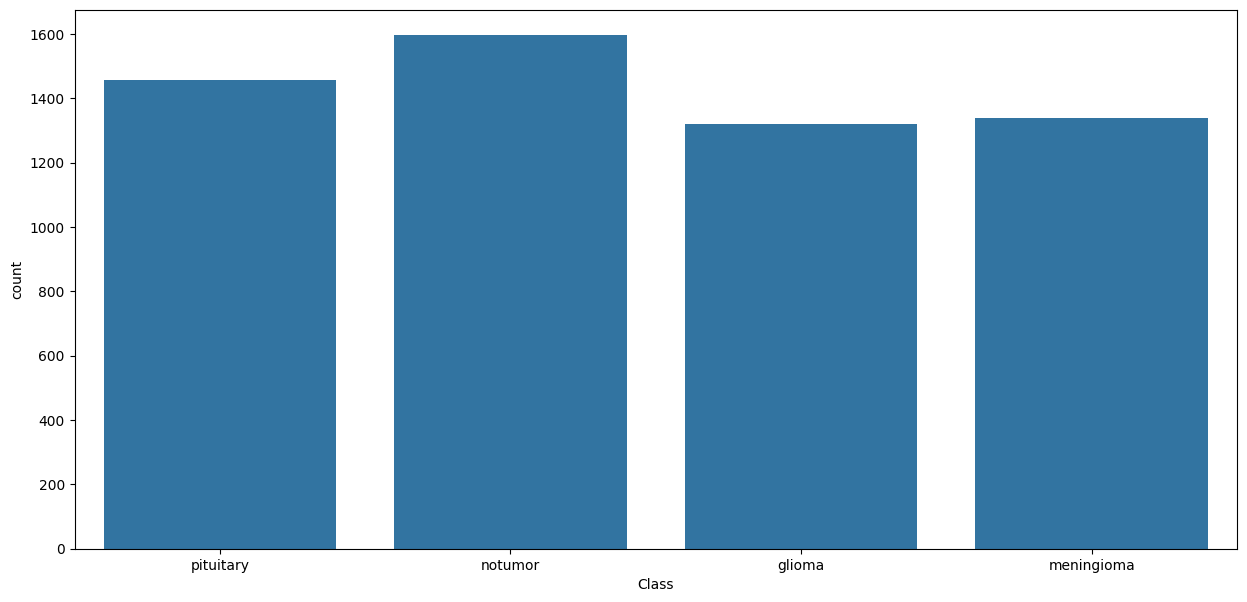

In [24]:
plt.figure(figsize=(15, 7))
sns.countplot(x=tr_df["Class"], data=tr_df) 

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [26]:
valid_df ,ts_df = train_test_split(ts_df, test_size=0.5, random_state=42)

In [27]:
valid_df

,Class Path,Class
7,Testing/pituitary/Te-pi_0179.jpg,pituitary
666,Testing/notumor/Te-no_0314.jpg,notumor
1074,Testing/meningioma/Te-me_0249.jpg,meningioma
357,Testing/notumor/Te-no_0084.jpg,notumor
329,Testing/notumor/Te-no_0050.jpg,notumor
...,...,...
1095,Testing/meningioma/Te-me_0212.jpg,meningioma
1130,Testing/meningioma/Te-me_0160.jpg,meningioma
1294,Testing/meningioma/Te-me_0297.jpg,meningioma
860,Testing/glioma/Te-gl_0194.jpg,glioma


In [28]:
batch_size = 32
img_size = (299, 299)
image_generator = ImageDataGenerator(rescale=1/255, brightness_range= (0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)

In [29]:
tr_gen = image_generator.flow_from_dataframe(tr_df, x_col="Class Path",
                                             y_col="Class", 
                                             target_size=img_size, 
                                             batch_size=batch_size
                                             )

valid_gen = image_generator.flow_from_dataframe(valid_df, x_col="Class Path",
 y_col="Class", 
 target_size=img_size, 
 batch_size=batch_size
 )

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col="Class Path",
 y_col="Class", 
 target_size=img_size, 
 batch_size=16,
 shuffle=False
 )


Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


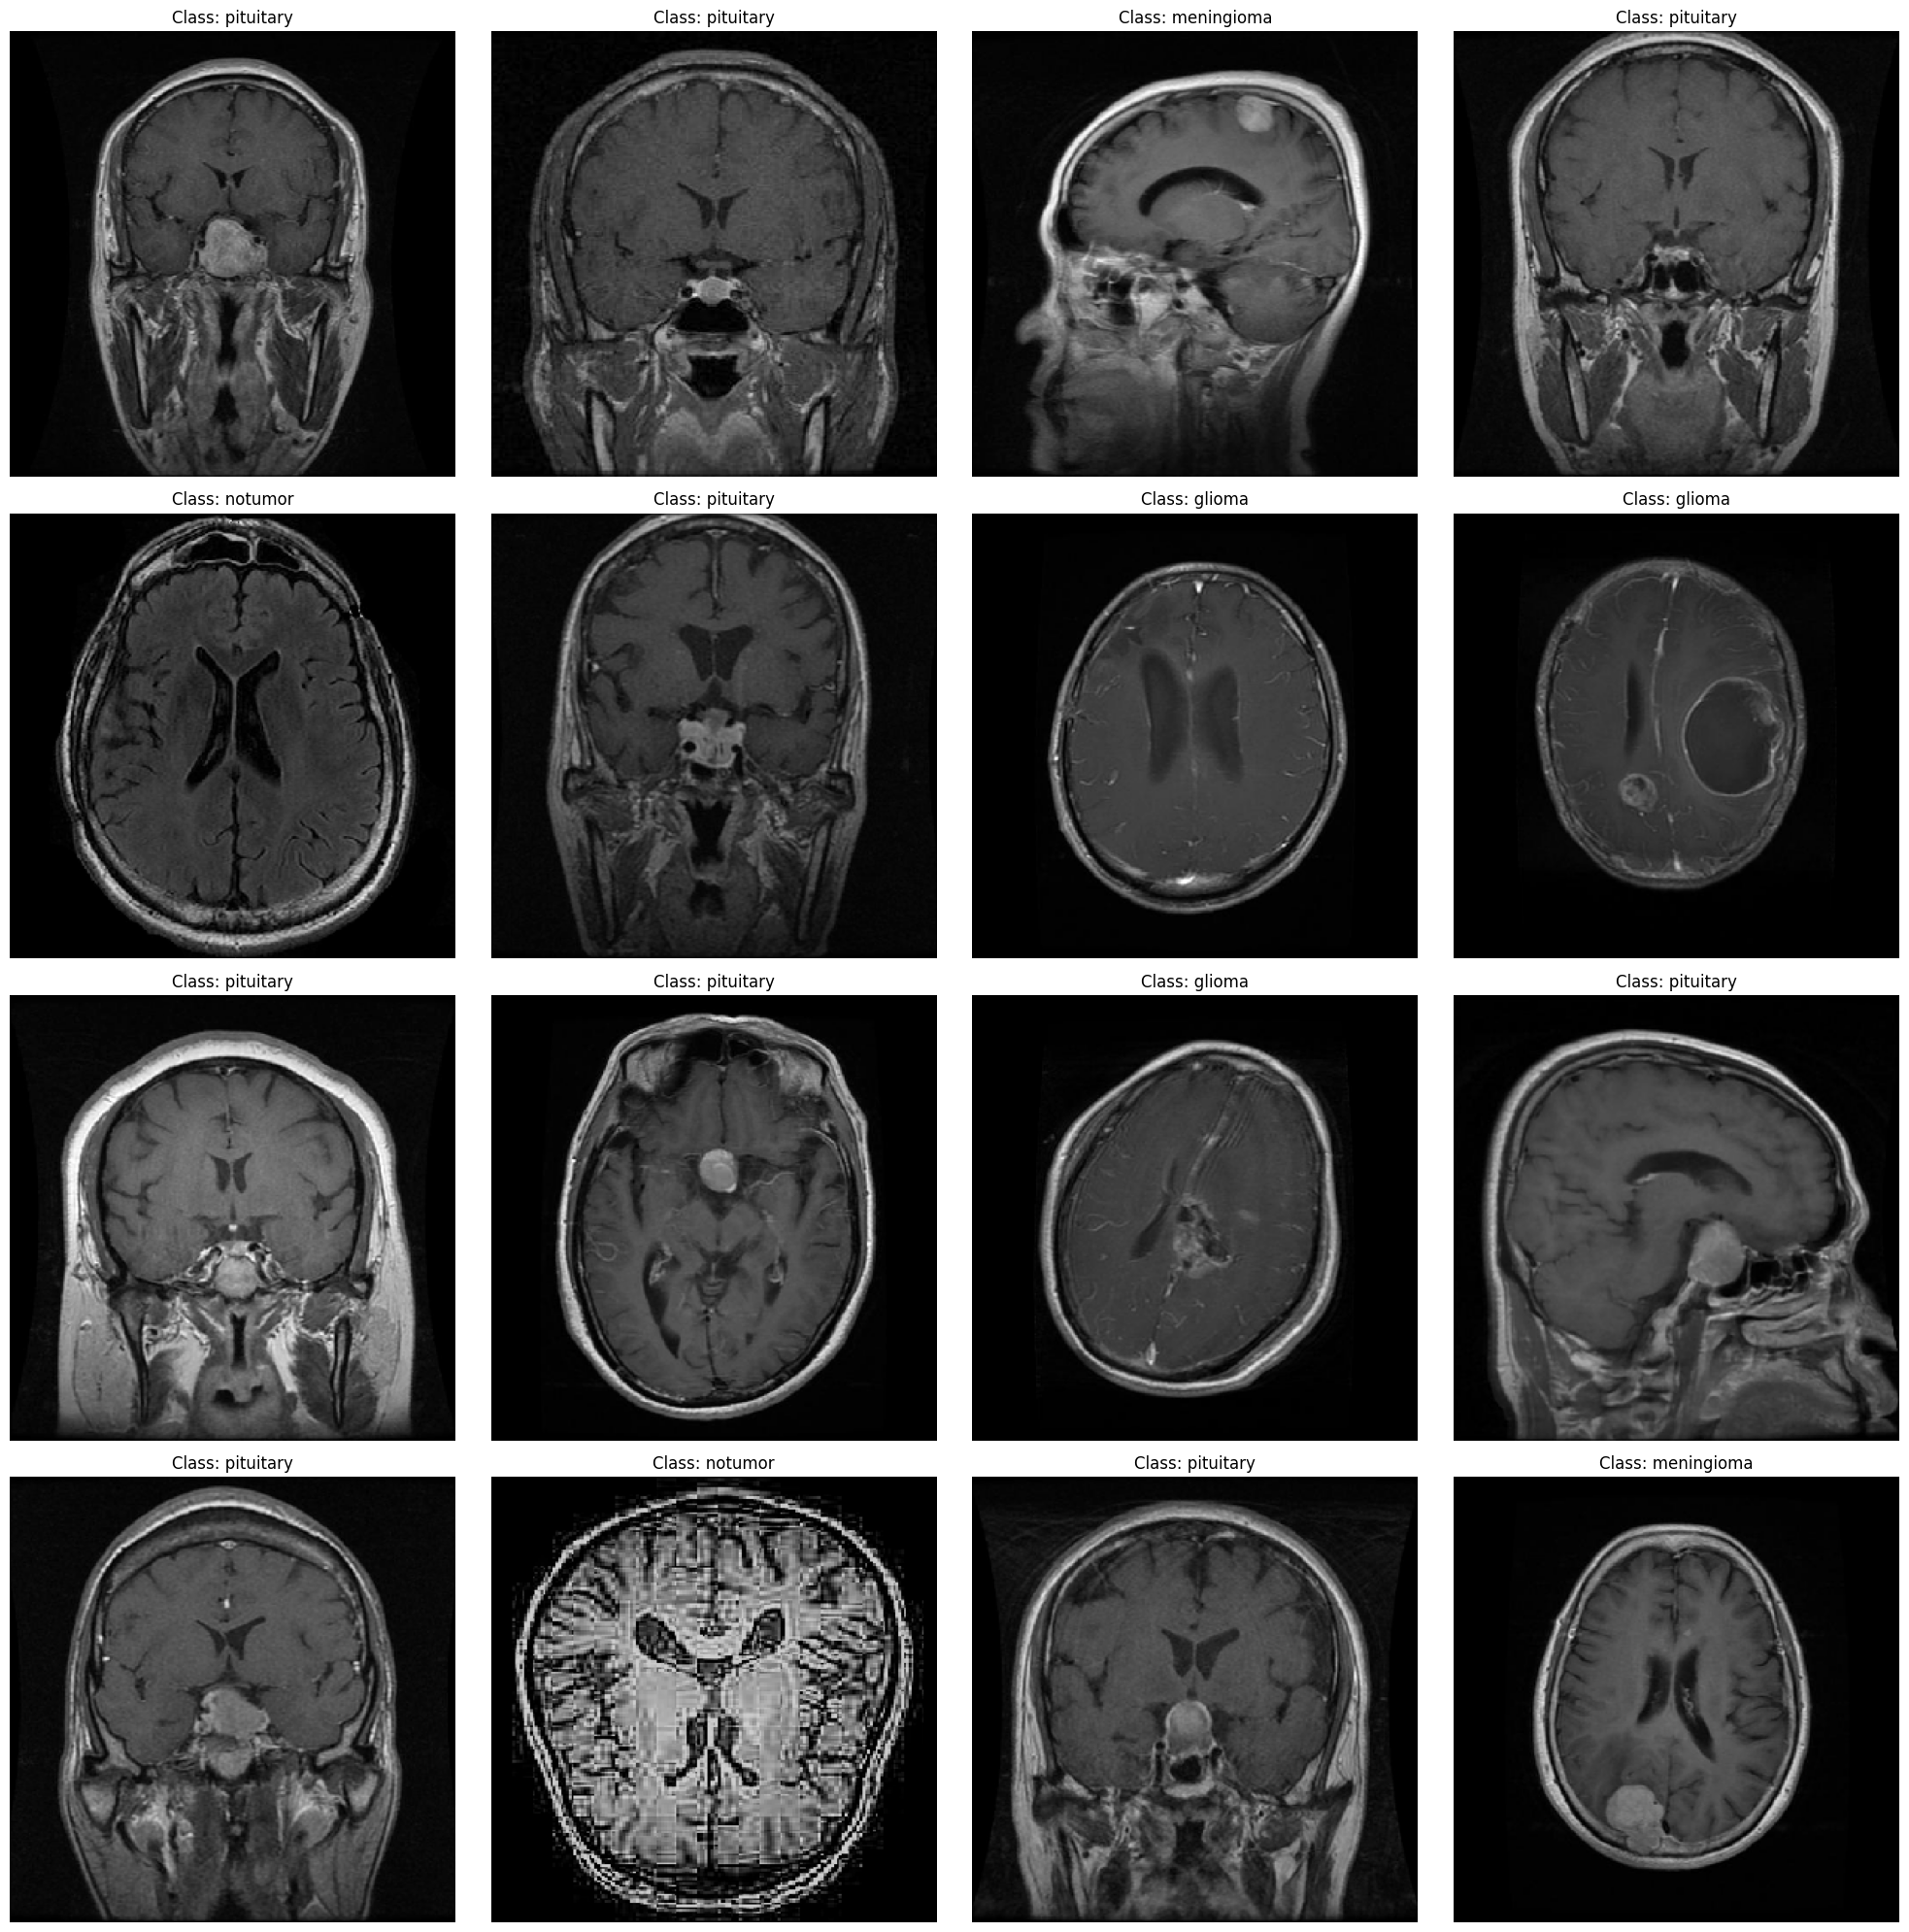

In [30]:
plt.figure(figsize=(20, 20))
for i in range(16):
    plt.subplot(4, 4, i+1)
    batch = next(tr_gen)
    image = batch[0][i]
    label = batch[1][i]
    plt.imshow(image)
    # Get the class index
    class_index = np.argmax(label)
    # Get the list of class names and class indices
    class_names = list(tr_gen.class_indices.keys())
    class_indices = list(tr_gen.class_indices.values())
    # Find the index of the class_index in the list of indices
    index_position = class_indices.index(class_index)
    # Get the class name using the index position
    class_name = class_names[index_position]
    plt.title(f"Class: {class_name}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [31]:

from tensorflow.keras.applications.xception import Xception

In [32]:
img_shape = (299, 299, 3)
base_model = Xception(
    weights='imagenet', 
    input_shape=img_shape,
    pooling='max'
)

model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate=0.25),
    Dense(4, activation= 'softmax'),
])

In [33]:
model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

In [1]:
from PIL import Image

def predict(img_path: str) -> None:
    # Get class labels
    flabels = list(class_dict.keys())
    
    # Create figure
    plt.figure(figsize=(6, 8))
    
    # Load and preprocess image
    img = Image.open(img_path)
    resized_img = img.resize((299, 299))
    img_array = np.asarray(resized_img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    
    # Get model predictions
    predictions = model.predict(img_array)
    probabilities = list(predictions[0])
    
    # Get predicted class
    predicted_class_idx = np.argmax(probabilities)
    predicted_class = class_dict[predicted_class_idx]
    
    # Plot original image
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.title(f"Input MRI Image\nPredicted: {predicted_class}")
    
    # Plot prediction probabilities
    plt.subplot(2, 1, 2)
    bars = plt.barh(flabels, probabilities)
    plt.xlabel("Probability", fontsize=15)
    plt.title("Class Probabilities")
    
    # Add probability labels to bars
    ax = plt.gca()
    ax.bar_label(bars, fmt="%.2f")
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nPredicted tumor type: {predicted_class}")

NameError: name 'model' is not defined

In [34]:
hist = model.fit(tr_gen,epochs=5,validation_data=valid_gen)

Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 5147s 29s/step - accuracy: 0.6049 - loss: 1.2473 - precision: 0.4392 - recall: 0.0279 - val_accuracy: 0.8046 - val_loss: 0.8771 - val_precision: 0.9182 - val_recall: 0.4458
Epoch 2/5
 90/179 ━━━━━━━━━━━━━━━━━━━━ 27:29 19s/step - accuracy: 0.6910 - loss: 0.8428 - precision: 0.9113 - recall: 0.5834

KeyboardInterrupt: 